In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
import calendar
import time

def get_data_by_hour(symbol):
    url = f"https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?region=US&lang=en-US&includePrePost=false&interval=1h&useYfid=true&range=1y&corsDomain=finance.yahoo.com&.tsrc=finance"
    yahooResponse = requests.get(url)
    yahooData = yahooResponse.json()['chart']['result'][0]
    data = {
          'open': yahooData['indicators']['quote'][0]['open'], 
          'high': yahooData['indicators']['quote'][0]['high'],
          'close': yahooData['indicators']['quote'][0]['close'],
          'volume': yahooData['indicators']['quote'][0]['volume'],
          'low': yahooData['indicators']['quote'][0]['low']
          }
    handledData = pd.DataFrame(data=data, index=pd.to_datetime(np.array(yahooData['timestamp']) * 1000, unit='ms').to_pydatetime())
    handledData.dropna(inplace=True)
    plt.figure(figsize=(15,5))
    plt.plot(handledData.index, handledData['close'])
    plt.grid(True)
    return handledData

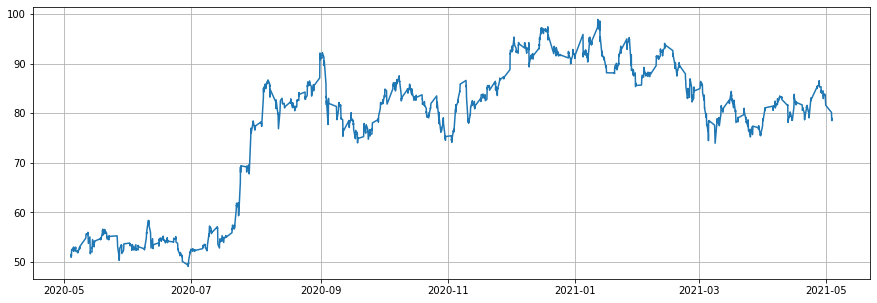

In [3]:
data_by_hour = get_data_by_hour('AMD')

In [4]:
data_by_hour.describe()

,open,high,close,volume,low
count,1757.000000,1757.000000,1757.000000,1.757000e+03,1757.000000
mean,77.476447,77.942754,77.456797,7.087118e+06,76.948291
std,13.744731,13.801150,13.734672,5.259157e+06,13.679339
min,49.127998,49.602200,49.125000,0.000000e+00,48.419998
25%,75.070000,75.830002,75.090103,3.913485e+06,74.500000
50%,81.709999,82.089996,81.699997,5.459044e+06,81.099998
75%,86.404999,86.839996,86.370003,8.232320e+06,85.940002
max,98.940002,99.230003,98.916801,6.046967e+07,98.410004


In [5]:
import calendar
import time

def get_data_by_min(symbol):
    period2 = calendar.timegm(time.gmtime())
    objects = []
    data = pd.DataFrame()
    for i in range(4):
        period1 = period2 - 604800
        url = f"https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?symbol={symbol}&period1={period1}&period2={period2}&useYfid=true&interval=1m&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=Uvl2JTAUYao&corsDomain=finance.yahoo.com"
        period2 = period1
        yahooResponse = requests.get(url)
        yahooData = yahooResponse.json()['chart']['result'][0]
        object_for_df = {
            'open': yahooData['indicators']['quote'][0]['open'], 
            'high': yahooData['indicators']['quote'][0]['high'],
            'close': yahooData['indicators']['quote'][0]['close'],
            'volume': yahooData['indicators']['quote'][0]['volume'],
            'low': yahooData['indicators']['quote'][0]['low']
        }
        objects.append({'data': object_for_df, 'timestamp': np.array(yahooData['timestamp'])})
    for i in range(-3,1):
        handledData = pd.DataFrame(data=objects[-i]['data'], index=pd.to_datetime(objects[-i]['timestamp'] * 1000, unit='ms').to_pydatetime())
        handledData[handledData['volume'] == 0] = None
        handledData.dropna(inplace=True)
        data.append(handledData)
    data.dropna(inplace=True)
    plt.figure(figsize=(15,5))
    plt.plot(handledData.index, handledData['close'])
    plt.grid(True)
    return handledData

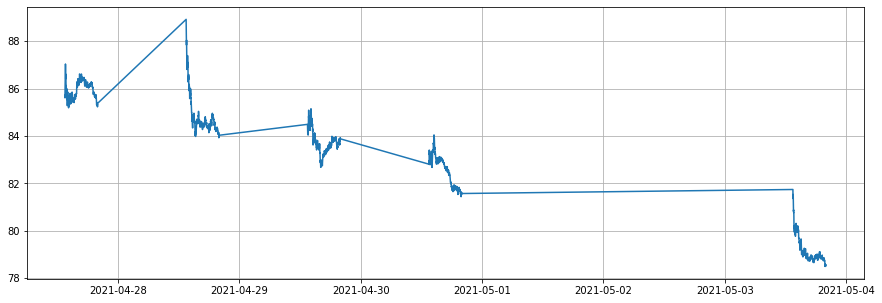

In [6]:
data_by_min = get_data_by_min('AMD')

In [7]:
class Stock:
    def cusum(self, raw,h, data):
        tEvents,values,sPos,sNeg = [],[],0,0
        diff = raw.diff()
        for i in diff.index[1:]:
            sPos, sNeg = max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
            if sNeg<-h:
                sNeg = 0
                tEvents.append(i)
                values.append(raw[i])
            elif sPos > h:
                sPos=0
                tEvents.append(i)
                values.append(raw[i])
        events = pd.DataFrame(data=values, index=tEvents)
        plt.figure(figsize=(15,5))
        plt.plot(data.index, raw)
        plt.plot(tEvents, values, '.')
        plt.title('cusum')
        plt.grid(True)
    
        plt.figure(figsize=(15,5))
        plt.plot(data.index[-100:], raw[-100:])
        plt.plot(tEvents[-20:], values[-20:], '.')
        plt.title('cusum last 100')
        plt.grid(True)
        return events
    
    def get_horizons(self, prices, delta):
        t1 = prices.index.searchsorted(prices.index + delta)
        t1 = t1[t1 < prices.shape[0]]
        t1 = prices.index[t1]
        t1 = pd.Series(t1, index=prices.index[:t1.shape[0]])
        return t1
    
    def get_vol(self, prices, span, delta):
        df0 = prices.index.searchsorted(prices.index - delta)
        df0 = df0[df0 > 0]  
        df0 = pd.Series(prices.index[df0-1], index=prices.index[prices.shape[0]-df0.shape[0]:])  
        df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1  
        df0 = df0.ewm(span=span).std()
        return df0
    
    def get_touches(self, prices, events, factors=[1, 1]):
        out = events[['t1']].copy(deep=True)
        if factors[0] > 0: thresh_uppr = factors[0] * events['threshold']
        else: thresh_uppr = pd.Series(index=events.index)
        if factors[1] > 0: thresh_lwr = -factors[1] * events['threshold']
        else: thresh_lwr = pd.Series(index=events.index) 
        for loc, t1 in events['t1'].iteritems():
            df0=prices[loc:t1]                              
            df0=(df0 / prices[loc] - 1) * events.side[loc] 
            out.loc[loc, 'stop_loss'] = df0[df0 < thresh_lwr[loc]].index.min()  
            out.loc[loc, 'take_profit'] = df0[df0 > thresh_uppr[loc]].index.min()
        return out
    
    def get_labels(self, touches):
        out = touches.copy(deep=True)
        first_touch = touches[['stop_loss', 'take_profit']].min(axis=1)
        for loc, t in first_touch.iteritems():
            if pd.isnull(t):
                out.loc[loc, 'label'] = 0
            elif t == touches.loc[loc, 'stop_loss']: 
                out.loc[loc, 'label'] = -1
            else:
                out.loc[loc, 'label'] = 1
        return out
    
    __cusum = cusum
    __get_horizons = get_horizons
    __get_vol = get_vol
    __get_touches = get_touches
    __get_labels = get_labels

    
    def __init__(self, data, horizons_delta):
        self.data = data
        
        self.__cusum(data['close'], 0.5, data)
        
        self.horizons = self.__get_horizons(data['close'], horizons_delta)
        self.threshold = self.__get_vol(data['close'], 100, horizons_delta)
        data_ohlc = pd.DataFrame(data=data)
        data_ohlc = data_ohlc.assign(t1=self.horizons).dropna()
        data_ohlc = data_ohlc.assign(threshold=self.threshold).dropna()
        self.events = data_ohlc[['t1', 'threshold']] 
        self.events = self.events.assign(side=pd.Series(1., self.events.index))
        
        self.touches = self.__get_touches(data['close'], self.events, [1,1])
        self.labels = self.__get_labels(self.touches)

        self.labels = self.labels.assign(t1_value=data.loc[self.labels['t1']]['close'].values)
        self.labels = self.labels.assign(stop_loss_value=[data.loc[sl]['close'] if not pd.isna(sl) else np.nan for sl in self.labels['stop_loss'].values])
        self.labels = self.labels.assign(take_profit_value=[data.loc[sl]['close'] if not pd.isna(sl) else np.nan for sl in self.labels['take_profit'].values])
        
        plt.figure(figsize=(15,5))
        plt.plot(data.index, data['close'])
        plt.plot(self.labels['stop_loss'].values, self.labels['stop_loss_value'].values, '.', label="stop_loss")
        plt.plot(self.labels['take_profit'].values, self.labels['take_profit_value'].values, '.', label="take_profit_value")

        plt.legend(loc='best')
        plt.title('labels')
        plt.grid(True)
        
        plt.figure(figsize=(15,5))
        plt.plot(data.index[-100:], data['close'][-100:], label="data")
        plt.plot(self.labels['stop_loss'].values[-100:], self.labels['stop_loss_value'].values[-100:], '.', label="stop_loss")
        plt.plot(self.labels['take_profit'].values[-100:], self.labels['take_profit_value'].values[-100:], '.', label="take_profit_value")
        plt.title('labels last 100')
        plt.legend(loc='best')
        plt.grid(True)
        

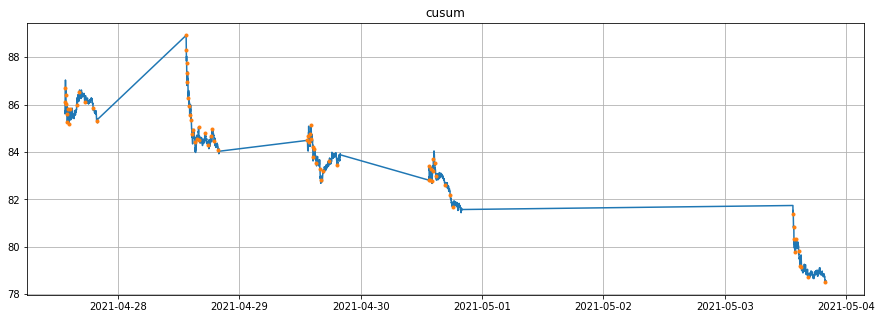

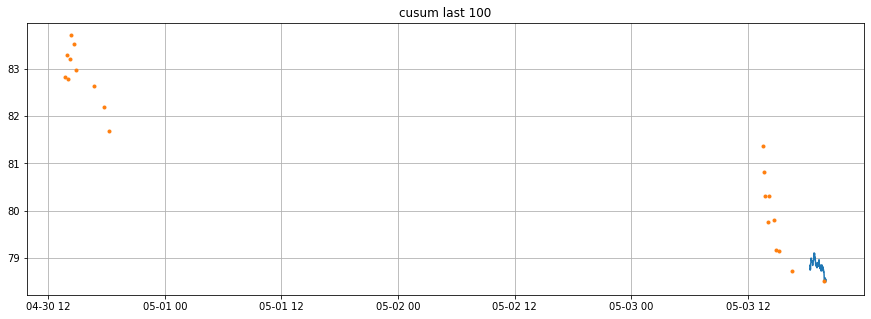

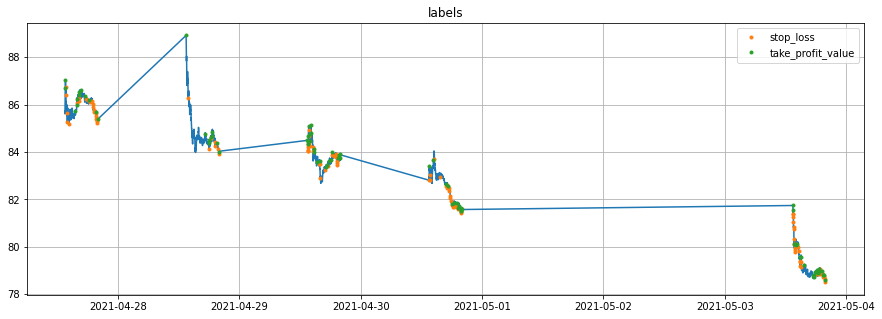

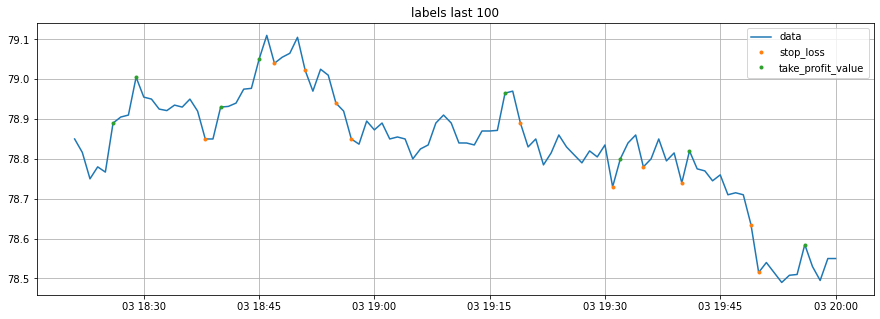

In [8]:
Stock(data_by_min, horizons_delta=pd.Timedelta(minutes=1))

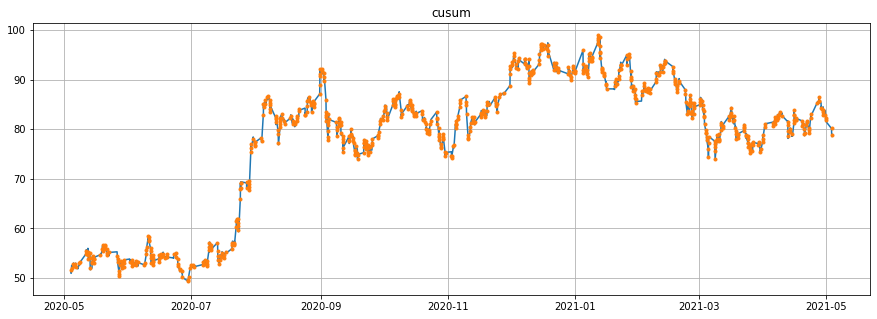

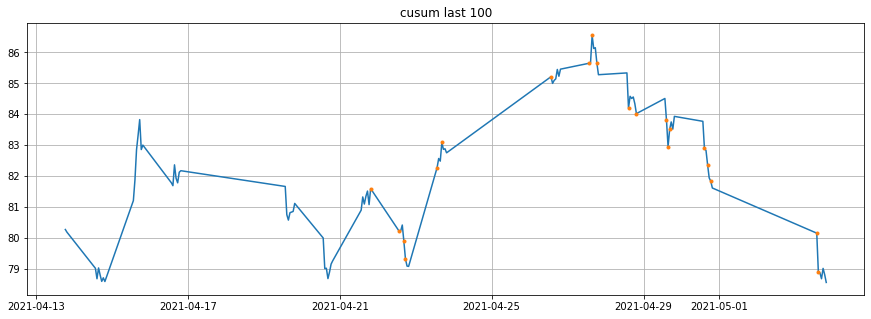

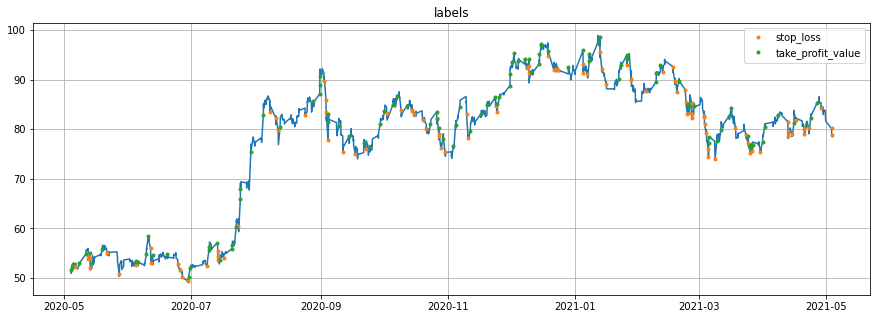

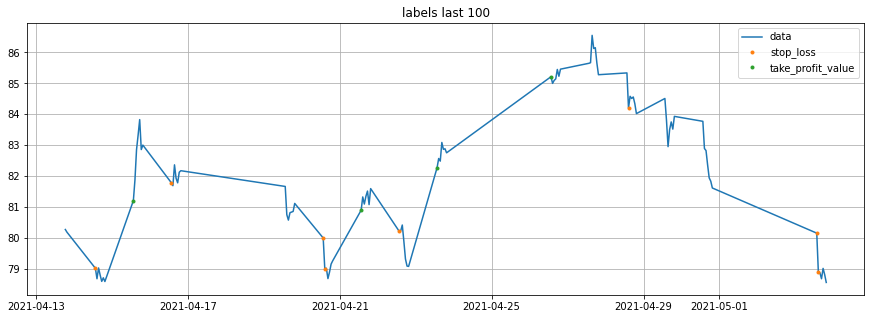

In [9]:
Stock(data_by_hour, horizons_delta=pd.Timedelta(hours=1))